In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [2]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

In [3]:
#1.1.1  1.1 모델 불러오기
import pickle
import joblib
best_lgbm_reg.booster_.save_model('mode.txt')
bst = lgb.Booster(model_file='mode.txt')

joblib.dump(best_lgbm_reg, 'lgb.pkl') #save
gbm_pickle = joblib.load('lgb.pkl') #load

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

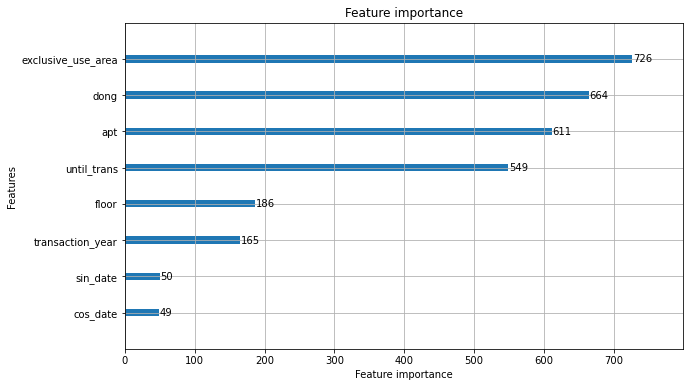

In [4]:
#1.1.2  1.2 Feature Importance 확인과 해석
#cos_date와 sin_date의 중요도는 조금 떨어지고 exclusive_use_area의 중요도가 제일 높게 나왔다. 
from lightgbm import LGBMClassifier, plot_importance
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(best_lgbm_reg, ax=ax)

In [5]:
#1.1.3  1.3 Randomness Control
import random
import os
np.random.seed(42)
os.urandom(42)

b'^\xe5\x10\xf3/\xe3-t\x060d\xa0\xb5L\xc2\x86\xa6\xbaw\x98V\xa5S\x80v\xe9G\x1b"\xc0\xab\xe5"Z\x85_\x81_\xcf\xc3/1'

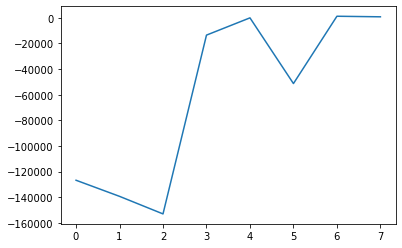

In [6]:
#1.1.4  1.4 Permutation Feature Importance
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_lgbm_reg, test_cbe, test_y, random_state=42)
plt.plot(perm.importances_mean)

In [7]:
! pip install shap

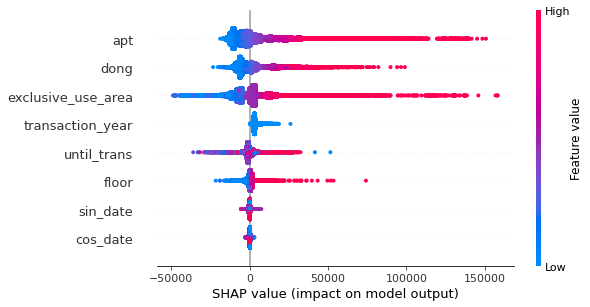

In [8]:
#1.1.5  1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석
#apt/dong/exclusive_use_area/until_trans/floor은 변수의 값이 높을수록 예상되는 가격(target:price)이 높은 경향성이 있다
#반면에 sin_date/cos_date는 해석하기 모호하다.

import shap
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0)).sort_values(ascending=False)
shap.summary_plot(shap_values, test_cbe)

In [9]:
#1.2.1  2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [14]:
model = build_model()
model.summary()
#순차모델sequential은 레이어 층을 더해주는 모델이다
#입력과 출력이 하나씩인 node를 만들어서 model에 연결시킨다.
#Dense로 만들어진 노드를 순차모델에 더하면 모델안에 있는 다른 노드들과 연결된다.
#첫번째 레이어같은 경우에는 입력값 8에 바이어스노드(1)=9개의 인풋 노드가 있고
#파라미터는 9 X 256으로 2304이다. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
#1.2.2  2.2 training loss와 validation loss를 시각화하세요.
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 2s 3ms/step - loss: 530659968.1569 - mse: 530659968.1569 - val_loss: 348122080.0000 - val_mse: 348122080.0000
Epoch 2/300
611/611 [==============================] - 1s 1ms/step - loss: 227264162.9020 - mse: 227264162.9020 - val_loss: 342113920.0000 - val_mse: 342113920.0000
Epoch 3/300
611/611 [==============================] - 1s 1ms/step - loss: 233709602.3529 - mse: 233709602.3529 - val_loss: 329141856.0000 - val_mse: 329141856.0000
Epoch 4/300
611/611 [==============================] - 1s 1ms/step - loss: 236664009.9869 - mse: 236664009.9869 - val_loss: 338681056.0000 - val_mse: 338681056.0000
Epoch 5/300
611/611 [==============================] - 1s 1ms/step - loss: 234722203.6078 - mse: 234722203.6078 - val_loss: 351802048.0000 - val_mse: 351802048.0000
Epoch 6/300
611/611 [==============================] - 1s 1ms/step - loss: 231197149.8562 - mse: 231197149.8562 - val_loss: 346941824.0000 - val_mse: 346941824.0000
Epoch 7/30

611/611 [==============================] - 1s 1ms/step - loss: 195419723.0588 - mse: 195419723.0588 - val_loss: 337826464.0000 - val_mse: 337826464.0000
Epoch 51/300
611/611 [==============================] - 1s 1ms/step - loss: 191018646.9542 - mse: 191018646.9542 - val_loss: 336068480.0000 - val_mse: 336068480.0000
Epoch 52/300
611/611 [==============================] - 1s 1ms/step - loss: 193469250.7190 - mse: 193469250.7190 - val_loss: 321158976.0000 - val_mse: 321158976.0000
Epoch 53/300
611/611 [==============================] - 1s 1ms/step - loss: 186930925.5033 - mse: 186930925.5033 - val_loss: 321152320.0000 - val_mse: 321152320.0000
Epoch 54/300
611/611 [==============================] - 1s 1ms/step - loss: 193737843.3203 - mse: 193737843.3203 - val_loss: 306582528.0000 - val_mse: 306582528.0000
Epoch 55/300
611/611 [==============================] - 1s 1ms/step - loss: 190835361.5686 - mse: 190835361.5686 - val_loss: 305290016.0000 - val_mse: 305290016.0000
Epoch 56/300
611/

611/611 [==============================] - 1s 1ms/step - loss: 173776861.2026 - mse: 173776861.2026 - val_loss: 415578144.0000 - val_mse: 415578144.0000
Epoch 100/300
611/611 [==============================] - 1s 1ms/step - loss: 182929990.9281 - mse: 182929990.9281 - val_loss: 316668800.0000 - val_mse: 316668800.0000
Epoch 101/300
611/611 [==============================] - 1s 1ms/step - loss: 178781813.9869 - mse: 178781813.9869 - val_loss: 303537920.0000 - val_mse: 303537920.0000
Epoch 102/300
611/611 [==============================] - 1s 1ms/step - loss: 177782113.1373 - mse: 177782113.1373 - val_loss: 265109968.0000 - val_mse: 265109968.0000
Epoch 103/300
611/611 [==============================] - 1s 1ms/step - loss: 176977434.4706 - mse: 176977434.4706 - val_loss: 288974144.0000 - val_mse: 288974144.0000
Epoch 104/300
611/611 [==============================] - 1s 1ms/step - loss: 178964520.9150 - mse: 178964520.9150 - val_loss: 283400608.0000 - val_mse: 283400608.0000
Epoch 105/30

611/611 [==============================] - 1s 1ms/step - loss: 173983974.2745 - mse: 173983974.2745 - val_loss: 268376704.0000 - val_mse: 268376704.0000
Epoch 149/300
611/611 [==============================] - 1s 1ms/step - loss: 178114879.7908 - mse: 178114879.7908 - val_loss: 238600544.0000 - val_mse: 238600544.0000
Epoch 150/300
611/611 [==============================] - 1s 1ms/step - loss: 166141895.9739 - mse: 166141895.9739 - val_loss: 274320544.0000 - val_mse: 274320544.0000
Epoch 151/300
611/611 [==============================] - 1s 1ms/step - loss: 173183139.0065 - mse: 173183139.0065 - val_loss: 312865856.0000 - val_mse: 312865856.0000
Epoch 152/300
611/611 [==============================] - 1s 1ms/step - loss: 177108115.4771 - mse: 177108115.4771 - val_loss: 288051168.0000 - val_mse: 288051168.0000
Epoch 153/300
611/611 [==============================] - 1s 1ms/step - loss: 176491736.7974 - mse: 176491736.7974 - val_loss: 260980448.0000 - val_mse: 260980448.0000
Epoch 154/30

611/611 [==============================] - 1s 1ms/step - loss: 169356195.5033 - mse: 169356195.5033 - val_loss: 286080928.0000 - val_mse: 286080928.0000
Epoch 198/300
611/611 [==============================] - 1s 1ms/step - loss: 167836934.0654 - mse: 167836934.0654 - val_loss: 302300096.0000 - val_mse: 302300096.0000
Epoch 199/300
611/611 [==============================] - 1s 1ms/step - loss: 172192529.8562 - mse: 172192529.8562 - val_loss: 389060608.0000 - val_mse: 389060608.0000
Epoch 200/300
611/611 [==============================] - 1s 1ms/step - loss: 169192254.1307 - mse: 169192254.1307 - val_loss: 262264992.0000 - val_mse: 262264992.0000
Epoch 201/300
611/611 [==============================] - 1s 1ms/step - loss: 170802413.1895 - mse: 170802413.1895 - val_loss: 342392224.0000 - val_mse: 342392224.0000
Epoch 202/300
611/611 [==============================] - 1s 1ms/step - loss: 169994385.3987 - mse: 169994385.3987 - val_loss: 242405088.0000 - val_mse: 242405088.0000
Epoch 203/30

611/611 [==============================] - 1s 1ms/step - loss: 164854048.6275 - mse: 164854048.6275 - val_loss: 276725472.0000 - val_mse: 276725472.0000
Epoch 247/300
611/611 [==============================] - 1s 1ms/step - loss: 169246824.4183 - mse: 169246824.4183 - val_loss: 445400448.0000 - val_mse: 445400448.0000
Epoch 248/300
611/611 [==============================] - 1s 1ms/step - loss: 166137800.0784 - mse: 166137800.0784 - val_loss: 282289184.0000 - val_mse: 282289184.0000
Epoch 249/300
611/611 [==============================] - 1s 1ms/step - loss: 164363429.6340 - mse: 164363429.6340 - val_loss: 262071360.0000 - val_mse: 262071360.0000
Epoch 250/300
611/611 [==============================] - 1s 1ms/step - loss: 168034875.3333 - mse: 168034875.3333 - val_loss: 225417872.0000 - val_mse: 225417872.0000
Epoch 251/300
611/611 [==============================] - 1s 1ms/step - loss: 166825191.8954 - mse: 166825191.8954 - val_loss: 249708304.0000 - val_mse: 249708304.0000
Epoch 252/30

611/611 [==============================] - 1s 1ms/step - loss: 163532994.6405 - mse: 163532994.6405 - val_loss: 239091088.0000 - val_mse: 239091088.0000
Epoch 296/300
611/611 [==============================] - 1s 1ms/step - loss: 162537450.8627 - mse: 162537450.8627 - val_loss: 274219296.0000 - val_mse: 274219296.0000
Epoch 297/300
611/611 [==============================] - 1s 1ms/step - loss: 160453690.7974 - mse: 160453690.7974 - val_loss: 236012224.0000 - val_mse: 236012224.0000
Epoch 298/300
611/611 [==============================] - 1s 1ms/step - loss: 157350474.0915 - mse: 157350474.0915 - val_loss: 271995648.0000 - val_mse: 271995648.0000
Epoch 299/300
611/611 [==============================] - 1s 1ms/step - loss: 166792804.1569 - mse: 166792804.1569 - val_loss: 247213120.0000 - val_mse: 247213120.0000
Epoch 300/300
611/611 [==============================] - 1s 1ms/step - loss: 158932547.6471 - mse: 158932547.6471 - val_loss: 308109088.0000 - val_mse: 308109088.0000


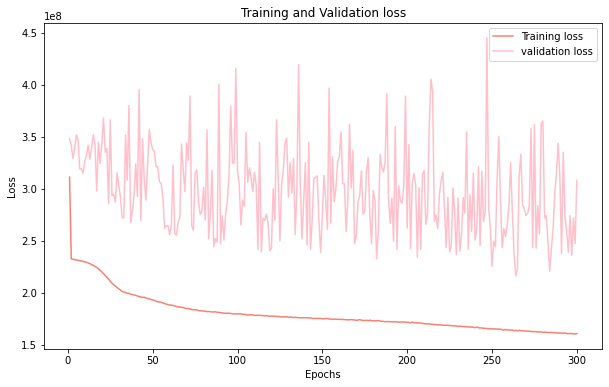

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,301)
plt.plot(epochs, loss_train, 'salmon', label='Training loss')
plt.plot(epochs, loss_val, 'pink', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#1.2.3  2.3 어떤문제가 발생했는지 설명해주세요.
#위에 나온 시각화와 같이 차분해보이는 training loss와 달리 validation loss에서 큰 fluctuation이 일어났다. 
#큰 fluctuation에는 정규화, batch size, Learning rate들이 원인이 될 수도 있다.
#이 상태로 model을 선택해도 상관은 없지만 최고의 모델을 뽑기위해서는 위와 같은 3가지 변수들을 조절하여서 더 나은 validation loss를 가져가면 좋을 것 같다.

#또한 딥러닝 적용 이전과 적용 후의 mse를 비교해 보았을때 많이 차이가 났기 때문에, 시각화에서도 보여지듯이, mse가 커지면서
#validation loss도 증가하면서 overfitting이 발생하였다..

In [18]:
#1.2.4  2.4 더 좋은 성능의 딥러닝 모델을 위해
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [20]:
history = model.fit(test_cbe,test_y, epochs=300, validation_data = (train_cbe,train_y), batch_size = 200)

Epoch 1/300
457/457 [==============================] - 1s 3ms/step - loss: 1650.0736 - mse: 1650.0736 - val_loss: 3337024768.0000 - val_mse: 3337024768.0000
Epoch 2/300
457/457 [==============================] - 1s 3ms/step - loss: 1647.2990 - mse: 1647.2990 - val_loss: 3335008768.0000 - val_mse: 3335008768.0000
Epoch 3/300
457/457 [==============================] - 1s 3ms/step - loss: 1618.0593 - mse: 1618.0593 - val_loss: 3335838464.0000 - val_mse: 3335838464.0000
Epoch 4/300
457/457 [==============================] - 1s 3ms/step - loss: 1602.0575 - mse: 1602.0575 - val_loss: 3332180992.0000 - val_mse: 3332180992.0000
Epoch 5/300
457/457 [==============================] - 1s 3ms/step - loss: 1571.0040 - mse: 1571.0040 - val_loss: 3336403968.0000 - val_mse: 3336403968.0000
Epoch 6/300
457/457 [==============================] - 1s 3ms/step - loss: 1576.1238 - mse: 1576.1238 - val_loss: 3332990208.0000 - val_mse: 3332989440.0000
Epoch 7/300
457/457 [==============================] - 1s 

Epoch 53/300
457/457 [==============================] - 1s 3ms/step - loss: 1127.5154 - mse: 1127.5154 - val_loss: 3333560832.0000 - val_mse: 3333560832.0000
Epoch 54/300
457/457 [==============================] - 1s 3ms/step - loss: 1134.5184 - mse: 1134.5183 - val_loss: 3334743808.0000 - val_mse: 3334743808.0000
Epoch 55/300
457/457 [==============================] - 2s 3ms/step - loss: 1100.8375 - mse: 1100.8375 - val_loss: 3334141952.0000 - val_mse: 3334141952.0000
Epoch 56/300
457/457 [==============================] - 1s 3ms/step - loss: 1182.6917 - mse: 1182.6917 - val_loss: 3332632576.0000 - val_mse: 3332632576.0000
Epoch 57/300
457/457 [==============================] - 1s 3ms/step - loss: 1113.6074 - mse: 1113.6074 - val_loss: 3333293568.0000 - val_mse: 3333293568.0000
Epoch 58/300
457/457 [==============================] - 1s 3ms/step - loss: 1114.9718 - mse: 1114.9718 - val_loss: 3332425216.0000 - val_mse: 3332425216.0000
Epoch 59/300
457/457 [==============================

457/457 [==============================] - 2s 3ms/step - loss: 892.2770 - mse: 892.2770 - val_loss: 3333996800.0000 - val_mse: 3333996800.0000
Epoch 106/300
457/457 [==============================] - 2s 3ms/step - loss: 893.6666 - mse: 893.6666 - val_loss: 3335700224.0000 - val_mse: 3335700224.0000
Epoch 107/300
457/457 [==============================] - 1s 3ms/step - loss: 891.2437 - mse: 891.2437 - val_loss: 3336143616.0000 - val_mse: 3336143616.0000
Epoch 108/300
457/457 [==============================] - 1s 3ms/step - loss: 884.3147 - mse: 884.3147 - val_loss: 3335399168.0000 - val_mse: 3335399168.0000
Epoch 109/300
457/457 [==============================] - 1s 3ms/step - loss: 891.4020 - mse: 891.4020 - val_loss: 3333192704.0000 - val_mse: 3333192704.0000
Epoch 110/300
457/457 [==============================] - 1s 3ms/step - loss: 871.9341 - mse: 871.9341 - val_loss: 3335424768.0000 - val_mse: 3335424768.0000
Epoch 111/300
457/457 [==============================] - 1s 3ms/step - l

457/457 [==============================] - 1s 3ms/step - loss: 757.6161 - mse: 757.6161 - val_loss: 3335666176.0000 - val_mse: 3335666176.0000
Epoch 158/300
457/457 [==============================] - 1s 3ms/step - loss: 759.4532 - mse: 759.4532 - val_loss: 3334494976.0000 - val_mse: 3334495232.0000
Epoch 159/300
457/457 [==============================] - 1s 3ms/step - loss: 754.5610 - mse: 754.5610 - val_loss: 3333610752.0000 - val_mse: 3333610752.0000
Epoch 160/300
457/457 [==============================] - 1s 3ms/step - loss: 751.6984 - mse: 751.6984 - val_loss: 3337353472.0000 - val_mse: 3337353472.0000
Epoch 161/300
457/457 [==============================] - 1s 3ms/step - loss: 745.8612 - mse: 745.8612 - val_loss: 3333053696.0000 - val_mse: 3333053696.0000
Epoch 162/300
457/457 [==============================] - 1s 3ms/step - loss: 752.0797 - mse: 752.0797 - val_loss: 3335848448.0000 - val_mse: 3335848448.0000
Epoch 163/300
457/457 [==============================] - 1s 3ms/step - l

457/457 [==============================] - 1s 3ms/step - loss: 679.6393 - mse: 679.6393 - val_loss: 3335684608.0000 - val_mse: 3335684608.0000
Epoch 210/300
457/457 [==============================] - 1s 3ms/step - loss: 669.3860 - mse: 669.3860 - val_loss: 3337319936.0000 - val_mse: 3337319936.0000
Epoch 211/300
457/457 [==============================] - 1s 3ms/step - loss: 679.5293 - mse: 679.5293 - val_loss: 3334759168.0000 - val_mse: 3334759168.0000
Epoch 212/300
457/457 [==============================] - 1s 3ms/step - loss: 678.6948 - mse: 678.6948 - val_loss: 3334696448.0000 - val_mse: 3334696448.0000
Epoch 213/300
457/457 [==============================] - 1s 3ms/step - loss: 669.9537 - mse: 669.9537 - val_loss: 3336142080.0000 - val_mse: 3336142080.0000
Epoch 214/300
457/457 [==============================] - 1s 3ms/step - loss: 678.5757 - mse: 678.5757 - val_loss: 3335131648.0000 - val_mse: 3335131648.0000
Epoch 215/300
457/457 [==============================] - 1s 3ms/step - l

457/457 [==============================] - 1s 3ms/step - loss: 616.2542 - mse: 616.2541 - val_loss: 3336152320.0000 - val_mse: 3336152320.0000
Epoch 262/300
457/457 [==============================] - 2s 4ms/step - loss: 626.5571 - mse: 626.5571 - val_loss: 3335956736.0000 - val_mse: 3335956736.0000
Epoch 263/300
457/457 [==============================] - 2s 4ms/step - loss: 618.6578 - mse: 618.6578 - val_loss: 3336318208.0000 - val_mse: 3336318208.0000
Epoch 264/300
457/457 [==============================] - 2s 4ms/step - loss: 618.0972 - mse: 618.0972 - val_loss: 3336486656.0000 - val_mse: 3336486656.0000
Epoch 265/300
457/457 [==============================] - 2s 4ms/step - loss: 610.8871 - mse: 610.8871 - val_loss: 3337174784.0000 - val_mse: 3337174784.0000
Epoch 266/300
457/457 [==============================] - 2s 4ms/step - loss: 620.0920 - mse: 620.0922 - val_loss: 3335518720.0000 - val_mse: 3335518720.0000
Epoch 267/300
457/457 [==============================] - 2s 3ms/step - l